# Test case for Data Analyst/Data Scientist

1. Необходимо рассчитать текущий LTV юзера, используя когортный анализ (cohorting event -
оформление пробного периода, когорта представляет собой кол-во возможных операций).
2. Спрогнозировать, каким будет LTV на полгода.
3. Построить график, который будет отображать кривую фактического LTV на фоне кривой
прогнозируемого LTV.
4. Рассчитать ROMI на 4 недели и на полгода, если стоимость привлечения пользователя,
который оформил подписку - 6 USD (ROMI нужно брать операционный, а не бухгалтерский,
цель: узнать как окупятся наши инвестиции).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import optimize

%matplotlib inline

## EDA

In [2]:
df = pd.read_excel('test case data analyst.xlsx')

In [3]:
df.head()

,product_id,quantity,is_trial_period,purchase_date,user_id
0,1week_4.99_USD_subscription_7days_trial,1,False,2020-02-19,9484222
1,1week_4.99_USD_subscription_7days_trial,1,False,2020-02-17,9422402
2,1week_4.99_USD_subscription_7days_trial,1,False,2020-02-18,4997991
3,1week_4.99_USD_subscription_7days_trial,1,False,2020-02-18,9455582
4,1week_4.99_USD_subscription_7days_trial,1,False,2020-02-16,8803657


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114200 entries, 0 to 114199
Data columns (total 5 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   product_id       114200 non-null  object        
 1   quantity         114200 non-null  int64         
 2   is_trial_period  114200 non-null  bool          
 3   purchase_date    114200 non-null  datetime64[ns]
 4   user_id          114200 non-null  int64         
dtypes: bool(1), datetime64[ns](1), int64(2), object(1)
memory usage: 3.6+ MB


In [5]:
# check number of unique values in each column
df.nunique()

product_id             1
quantity               1
is_trial_period        2
purchase_date         51
user_id            62909
dtype: int64

In [9]:
# check NA
df.isnull().sum()

product_id         0
quantity           0
is_trial_period    0
purchase_date      0
user_id            0
dtype: int64

In [10]:
# check the maximum and minimum date
print('MAX date: ', df.purchase_date.max())
print('MIN date: ', df.purchase_date.min())

MAX date:  2020-02-20 00:00:00
MIN date:  2020-01-01 00:00:00


In [11]:
# check repeated users in column "user_id"
len(df.user_id) - df.user_id.nunique()

51291

## Pre-processing

In [12]:
# check users, who purchased more than once in one day
df_temp = df.groupby(['user_id','purchase_date' ]).agg({'quantity' : 'count'})
df_temp[df_temp['quantity'] > 1]

,,quantity
user_id,purchase_date,
1335694,2020-01-24,2
1639577,2020-01-10,2
5943648,2020-02-11,2
7346601,2020-01-14,3
8206996,2020-02-04,2
...,...,...
9443919,2020-02-10,2
9527949,2020-02-13,3
9536585,2020-02-14,2


In [13]:
df[df['user_id'] == 9584301].sort_values('purchase_date')

,product_id,quantity,is_trial_period,purchase_date,user_id
89069,1week_4.99_USD_subscription_7days_trial,1,True,2020-02-01,9584301
81493,1week_4.99_USD_subscription_7days_trial,1,False,2020-02-08,9584301
71953,1week_4.99_USD_subscription_7days_trial,1,False,2020-02-15,9584301
57784,1week_4.99_USD_subscription_7days_trial,1,False,2020-02-16,9584301
62260,1week_4.99_USD_subscription_7days_trial,1,False,2020-02-16,9584301
72430,1week_4.99_USD_subscription_7days_trial,1,False,2020-02-16,9584301
82156,1week_4.99_USD_subscription_7days_trial,1,False,2020-02-16,9584301
82951,1week_4.99_USD_subscription_7days_trial,1,False,2020-02-16,9584301
83300,1week_4.99_USD_subscription_7days_trial,1,False,2020-02-16,9584301
92931,1week_4.99_USD_subscription_7days_trial,1,False,2020-02-16,9584301


In [14]:
# drop duplicates
df = df.drop_duplicates()

In [17]:
# add price to sum this price for each user
df.loc[:, 'price'] = 0

# assign a value = 0 for users who did not buy (is_trial_period == True)
df.loc[df.is_trial_period == False, 'price'] = 4.99

In [18]:
df[df['user_id'] == 9584301].sort_values('purchase_date')

,product_id,quantity,is_trial_period,purchase_date,user_id,price
89069,1week_4.99_USD_subscription_7days_trial,1,True,2020-02-01,9584301,0.00
81493,1week_4.99_USD_subscription_7days_trial,1,False,2020-02-08,9584301,4.99
71953,1week_4.99_USD_subscription_7days_trial,1,False,2020-02-15,9584301,4.99
57784,1week_4.99_USD_subscription_7days_trial,1,False,2020-02-16,9584301,4.99


In [19]:
# create table with first activity date of each user
df_temp = df.groupby('user_id').agg({'purchase_date' : 'min'}).rename(columns={'purchase_date' : 'reg_day'})
df_temp.head()

,reg_day
user_id,
404,2020-02-03
5337,2020-02-17
9010,2020-01-27
19880,2020-01-30
23403,2020-01-20


In [20]:
# add reg date to our data
df = df.merge(df_temp, how='left', on='user_id')
df.head()

,product_id,quantity,is_trial_period,purchase_date,user_id,price,reg_day
0,1week_4.99_USD_subscription_7days_trial,1,False,2020-02-19,9484222,4.99,2020-02-12
1,1week_4.99_USD_subscription_7days_trial,1,False,2020-02-17,9422402,4.99,2020-02-10
2,1week_4.99_USD_subscription_7days_trial,1,False,2020-02-18,4997991,4.99,2020-02-11
3,1week_4.99_USD_subscription_7days_trial,1,False,2020-02-18,9455582,4.99,2020-02-11
4,1week_4.99_USD_subscription_7days_trial,1,False,2020-02-16,8803657,4.99,2020-01-19


In [22]:
# add new colums of the purchase week and registration week
df['purchase_week'] = df['purchase_date'] - df['purchase_date'].dt.weekday.astype('timedelta64[D]')
df['reg_week']      = df['reg_day'] - df['reg_day'].dt.weekday.astype('timedelta64[D]')

In [23]:
df.head()

,product_id,quantity,is_trial_period,purchase_date,user_id,price,reg_day,purchase_week,reg_week
0,1week_4.99_USD_subscription_7days_trial,1,False,2020-02-19,9484222,4.99,2020-02-12,2020-02-17,2020-02-10
1,1week_4.99_USD_subscription_7days_trial,1,False,2020-02-17,9422402,4.99,2020-02-10,2020-02-17,2020-02-10
2,1week_4.99_USD_subscription_7days_trial,1,False,2020-02-18,4997991,4.99,2020-02-11,2020-02-17,2020-02-10
3,1week_4.99_USD_subscription_7days_trial,1,False,2020-02-18,9455582,4.99,2020-02-11,2020-02-17,2020-02-10
4,1week_4.99_USD_subscription_7days_trial,1,False,2020-02-16,8803657,4.99,2020-01-19,2020-02-10,2020-01-13


## Calculating LTV with cohort analysis

In [24]:
# find the cohort life time
df['cohort_lifetime'] = ((df['purchase_week'] - df['reg_week']) / np.timedelta64(7,'D')).astype(int)
df

,product_id,quantity,is_trial_period,purchase_date,user_id,price,reg_day,purchase_week,reg_week,cohort_lifetime
0,1week_4.99_USD_subscription_7days_trial,1,False,2020-02-19,9484222,4.99,2020-02-12,2020-02-17,2020-02-10,1
1,1week_4.99_USD_subscription_7days_trial,1,False,2020-02-17,9422402,4.99,2020-02-10,2020-02-17,2020-02-10,1
2,1week_4.99_USD_subscription_7days_trial,1,False,2020-02-18,4997991,4.99,2020-02-11,2020-02-17,2020-02-10,1
3,1week_4.99_USD_subscription_7days_trial,1,False,2020-02-18,9455582,4.99,2020-02-11,2020-02-17,2020-02-10,1
4,1week_4.99_USD_subscription_7days_trial,1,False,2020-02-16,8803657,4.99,2020-01-19,2020-02-10,2020-01-13,4
...,...,...,...,...,...,...,...,...,...,...
114111,1week_4.99_USD_subscription_7days_trial,1,True,2020-01-04,8291100,0.00,2020-01-04,2019-12-30,2019-12-30,0
114112,1week_4.99_USD_subscription_7days_trial,1,True,2020-01-02,8236936,0.00,2020-01-02,2019-12-30,2019-12-30,0
114113,1week_4.99_USD_subscription_7days_trial,1,True,2020-01-03,8247910,0.00,2020-01-03,2019-12-30,2019-12-30,0
114114,1week_4.99_USD_subscription_7days_trial,1,True,2020-01-04,8294146,0.00,2020-01-04,2019-12-30,2019-12-30,0


In [25]:
# Calculate size of each cohort for registration week 
cohort_size = df.groupby(['reg_week']) \
              .agg({'user_id' : 'nunique'})\
              .reset_index() \
              .rename(columns={'user_id': 'weekly_users'})

In [26]:
cohort_size

,reg_week,weekly_users
0,2019-12-30,6629
1,2020-01-06,8429
2,2020-01-13,9134
3,2020-01-20,8185
4,2020-01-27,8315
5,2020-02-03,9066
6,2020-02-10,9038
7,2020-02-17,4113


In [28]:
# create a new dataframe with information about cohorts and their cumulative sum
cunsum_revenue_cohorts = df.groupby(['reg_week', 'cohort_lifetime']) \
            .agg({'price' : 'sum'}) \
            .groupby(level=0).cumsum() \
            .reset_index() \
            .rename(columns={'price':'cumsum_revenue'})

cunsum_revenue_cohorts.head()

,reg_week,cohort_lifetime,cumsum_revenue
0,2019-12-30,0,24.95
1,2019-12-30,1,12320.31
2,2019-12-30,2,22435.04
3,2019-12-30,3,31357.16
4,2019-12-30,4,39510.82


In [29]:
# merge cunsum_revenue_cohorts with cohort_size
ltv = cunsum_revenue_cohorts.merge(cohort_size, how='left', on='reg_week')
ltv.head()

,reg_week,cohort_lifetime,cumsum_revenue,weekly_users
0,2019-12-30,0,24.95,6629
1,2019-12-30,1,12320.31,6629
2,2019-12-30,2,22435.04,6629
3,2019-12-30,3,31357.16,6629
4,2019-12-30,4,39510.82,6629


### 1. Необходимо рассчитать текущий LTV юзера, используя когортный анализ (cohorting event - оформление пробного периода, когорта представляет собой кол-во возможных операций).

In [30]:
ltv['ltv'] = round(ltv['cumsum_revenue'] / ltv['weekly_users'], 2)
ltv

,reg_week,cohort_lifetime,cumsum_revenue,weekly_users,ltv
0,2019-12-30,0,24.95,6629,0.00
1,2019-12-30,1,12320.31,6629,1.86
2,2019-12-30,2,22435.04,6629,3.38
3,2019-12-30,3,31357.16,6629,4.73
4,2019-12-30,4,39510.82,6629,5.96
5,2019-12-30,5,46940.93,6629,7.08
6,2019-12-30,6,53642.50,6629,8.09
7,2019-12-30,7,55259.26,6629,8.34
8,2020-01-06,0,14.97,8429,0.00
9,2020-01-06,1,14555.83,8429,1.73


In [31]:
ltv_pivot = ltv.pivot_table(index='reg_week', columns='cohort_lifetime', values='ltv')
ltv_pivot

cohort_lifetime,0,1,2,3,4,5,6,7
reg_week,,,,,,,,
2019-12-30,0.0,1.86,3.38,4.73,5.96,7.08,8.09,8.34
2020-01-06,0.0,1.73,3.14,4.38,5.48,6.48,6.90,NaN
2020-01-13,0.0,1.69,3.05,4.24,5.29,5.74,NaN,NaN
2020-01-20,0.0,1.60,2.83,3.87,4.33,NaN,NaN,NaN
2020-01-27,0.0,1.58,2.83,3.32,NaN,NaN,NaN,NaN
2020-02-03,0.0,1.57,2.15,NaN,NaN,NaN,NaN,NaN
2020-02-10,0.0,0.78,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-17,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


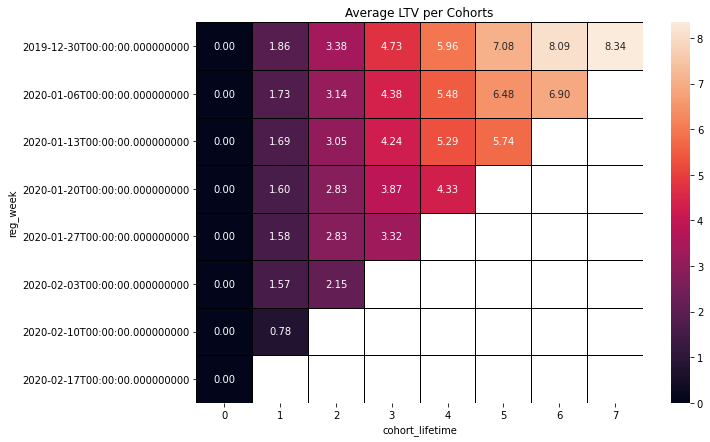

In [32]:
plt.figure(figsize=(10, 7))
plt.title('Average LTV per Cohorts')
sns.heatmap(ltv_pivot, annot=True, 
            fmt='.2f', linewidths=1, linecolor='black'); 

## LTV prediction

In [33]:
# Create a date frame with mean LTV  and the cohort number corresponding to the subscription week.
weekly_ltv = ltv.groupby('cohort_lifetime')\
                .agg({'ltv' : 'mean'}).reset_index()
weekly_ltv

,cohort_lifetime,ltv
0,0,0.000000
1,1,1.544286
2,2,2.896667
3,3,4.108000
4,4,5.265000
5,5,6.433333
6,6,7.495000
7,7,8.340000


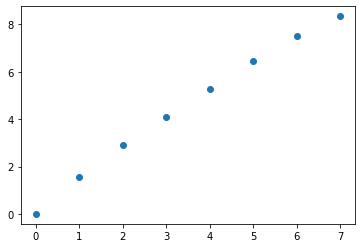

In [34]:
plt.scatter(x=weekly_ltv.cohort_lifetime, y=weekly_ltv.ltv)
plt.show()

In [36]:
# predict future ltv with simple log
x = weekly_ltv.cohort_lifetime
y = weekly_ltv.ltv

In [37]:
X_l = weekly_ltv[weekly_ltv['cohort_lifetime'] !=0 ].cohort_lifetime
Y_l = round(weekly_ltv[weekly_ltv['cohort_lifetime'] !=0 ].ltv, 2)

In [38]:
# find optimal coef for function a + b * np.log(t) , where t is number of the week
coefs_l, cov = optimize.curve_fit(lambda t,a,b: a + b * np.log(t),  X_l,  Y_l, maxfev=1000)
print(coefs_l)

[0.87286874 3.51546646]


In [39]:
# create a function to predict LTV 
def ltv_function(time):
    result = coefs_l[0] + coefs_l[1] * np.log(time)
    return result

### 2. Спрогнозировать, каким будет LTV на полгода.

In [40]:
ltv_8 = coefs_l[0] + coefs_l[1] * np.log(8)  # prediction of the ltv for week 8
ltv_9 = coefs_l[0] + coefs_l[1] * np.log(9)  # prediction of the ltv for week 9
ltv_26 = coefs_l[0] + coefs_l[1] * np.log(26)  # prediction of the ltv for week 26 (half of the year)

print('LTV (week 8) :', ltv_8)
print('LTV (week 9) :', ltv_9)
print('LTV (week 26) :', ltv_26)

LTV (week 8) : 8.183075736196537
LTV (week 9) : 8.597138047675603
LTV (week 26) : 12.326597844468163


In [41]:
weeks = np.hstack([weekly_ltv.cohort_lifetime,[8,9,12,15,18,26]])

### 3. Построить график, который будет отображать кривую фактического LTV на фоне кривой прогнозируемого LTV.

Text(0, 0.5, 'LTV')

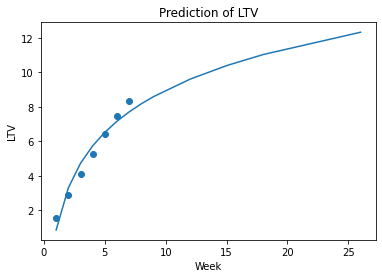

In [42]:
plt.scatter(x[1:], y[1:])
plt.plot(weeks[1:], ltv_function(weeks[1:]))
plt.title('Prediction of LTV')
plt.xlabel('Week')
plt.ylabel('LTV')

### 4. Рассчитать ROMI на 4 недели и на полгода, если стоимость привлечения платящего пользователя 6 USD (ROMI нужно брать операционный, а не бухгалтерский, цель: узнать как окупятся наши инвестиции).

In [43]:
# add date for our cohorts
weekly_ltv['date'] = ltv.reg_week.unique()
weekly_ltv

,cohort_lifetime,ltv,date
0,0,0.000000,2019-12-30
1,1,1.544286,2020-01-06
2,2,2.896667,2020-01-13
3,3,4.108000,2020-01-20
4,4,5.265000,2020-01-27
5,5,6.433333,2020-02-03
6,6,7.495000,2020-02-10
7,7,8.340000,2020-02-17


In [44]:
print('LTV for 4th week:', weekly_ltv['ltv'][3])

LTV for 4th week: 4.108


In [45]:
weekly_ltv['ltv']

0    0.000000
1    1.544286
2    2.896667
3    4.108000
4    5.265000
5    6.433333
6    7.495000
7    8.340000
Name: ltv, dtype: float64

In [46]:
ltv_week_4 = weekly_ltv['ltv'][3]
ltv_week_26 = ltv_function(26)
investment = 6  # investment 
ROMI_4 = (ltv_week_4 - investment)/investment *100  # Рассчитать ROMI на 4 недели
ROMI_26 = (ltv_week_26 - investment)/investment *100  # Рассчитать ROMI на  полгода

In [47]:
print('ROMI of the 4th week: {ROMI:.2f}%'.format(ROMI=ROMI_4))
print('ROMI of the 26th week: {ROMI:.2f}%'.format(ROMI=ROMI_26))

ROMI of the 4th week: -31.53%
ROMI of the 26th week: 105.44%


We can see that in **week 4** ROMI will be *-31.53%.*\
**Only after 6th week we will have positive ROMI. ROMI will be +7.16%**